# Notes on Classification

From Chapter 3 of Hands-On Machine Learning textbook by Aurelien Geron. 

In [76]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

import numpy as np
np.random.seed(42) #for reproducting code!

Datasets loaded by Scikit-Learn generally have a similar dictionary structure including:
- A DESCR key describing the dataset
- A data key containing an array with one row per instance and one column per feature
- A target key containing an array with the labels

In [77]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [78]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


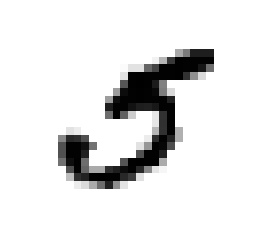

Label:  5.0


In [79]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
print(some_digit_image[0:5])

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,
          interpolation="nearest")
plt.axis("off")
plt.show()

#Neat, its a five!!!!! This is what the label says too.
print("Label: ",y[36000])

# Create a test set!
You should always create a test set and set it aside before inspecting the data closely. The
MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the
last 10,000 images)

In [80]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let’s also shuffle the training set; this will guarantee that all cross-validation folds will be similar
(you don’t want one fold to be missing some digits). Moreover, some learning algorithms are
sensitive to the order of the training instances, and they perform poorly if they get many similar
instances in a row. Shuffling the dataset ensures that this won’t happen

In [81]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [82]:
y_train

array([ 1.,  6.,  6., ...,  0.,  2.,  9.])

# Train a binary classifier!
Let’s simplify the problem for now and only try to identify one digit — for example, the number 5.
This “5-detector” will be an example of a binary classifier, capable of distinguishing between just
two classes, 5 and not-5. Let’s create the target vectors for this classification task:

In [83]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [84]:
y_train_5

array([False, False, False, ..., False, False, False], dtype=bool)

Okay, now let’s pick a classifier and train it. A good place to start is with a Stochastic Gradient
Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier has the
advantage of being capable of handling very large datasets efficiently. This is in part because SGD
deals with training instances independently, one at a time (which also makes SGD well suited for
online learning), as we will see later.

In [85]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3) #for reproducible results
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.001, verbose=0, warm_start=False)

In [86]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

Looks like it guesses true in this case, so it seems to predict correctly for this instance at least! Wooohooo!

# Performance Measures
Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will spend a
large part of this chapter on this topic. There are many performance measures available, so grab
another coffee and get ready to learn many new concepts and acronyms!

# Measuing Accuracy Using Cross-Validation
A good way to evaluate a model is to use cross-validation. 

Occasionally you will need more control over the cross-validation process than what cross_val_score() and similar functions
provide. In these cases, you can implement cross-validation yourself; it is actually fairly straightforward. The following code does
roughly the same thing as the preceding cross_val_score() code, and prints the same result:

In [87]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # prints 0.9502, 0.96565 and 0.96495


0.96735
0.9519
0.94085


# cross_val_score
Let’s use the cross_val_score() function to evaluate your SGDClassifier model using K-fold
cross-validation, with three folds. Remember that K-fold cross-validation means splitting the training
set into K-folds (in this case, three), then making predictions and evaluating them on each fold using a
model trained on the remaining folds


In [88]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, scoring="accuracy", cv=3)

array([ 0.96735,  0.9519 ,  0.94085])

90% accuracy! Great no?!?! Not so fast buster!!!! Lets create a reallllly bad classifier that predicts 0 for everything, and see how it performs.

In [89]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1),dtype=bool)

In [90]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.909  ,  0.90715,  0.9128 ])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s,
so if you always guess that an image is not a 5, you will be right about 90% of the time. **This demonstrates why accuracy is generally not the preferred performance measure for classifiers,
especially when you are dealing with skewed datasets (i.e., when some classes are much more
frequent than others).**

# Confusion Matrix
A much better way to evaluate a classifier is to look at a confusion matrix. General idea is to count the number of times instances of Class A are classified as Class B. For example, if you want to know the number of times the classifier confused an image of a 5 with a 3 you would look in the 5th row and 3rd column of the matrix. 

To compute the confusion matrix, you first need to have a set of predictions, so they can be compared
to the actual targets. You could make predictions on the test set, but let’s keep it untouched for now
(remember that you want to use the test set only at the very end of your project, once you have a
classifier that you are ready to launch). Instead, you can use the cross_val_predict() function.

Just like the cross_val_score() function, cross_val_predict() performs K-fold crossvalidation,
but instead of returning the evaluation scores, it returns the predictions made on each test
fold. This means that you get a clean prediction for each instance in the training set **(“clean” meaning
that the prediction is made by a model that never saw the data during training).**

In [91]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, )

Now you can get the confusion matrix using the confusion_matrix() function!

In [92]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53207,  1372],
       [ 1426,  3995]], dtype=int64)

In [93]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

#So you see, false negative and false positive are both zero!

array([[54579,     0],
       [    0,  5421]], dtype=int64)

# Precision and Recall
Precision: Out of all of the positives you identified, what percentage is correct.

Recall: Out of all TRUE positives, how many did you correctly identify

In [94]:
from sklearn.metrics import precision_score, recall_score
print("Precision Score: ", precision_score(y_train_5, y_train_pred))
print("Recall Score: ", recall_score(y_train_5, y_train_pred))

Precision Score:  0.744363704118
Recall Score:  0.736948902417


# F1 Score and Harmonic Mean
Now your 5-detector does not look as shiny as it did when you looked at its accuracy. When it claims
an image represents a 5, it is correct only 77% of the time. Moreover, it only detects 79% of the 5s.
It is often convenient to combine precision and recall into a single metric called the F1 score, in
particular if you need a simple way to compare two classifiers. **The F1 score is the harmonic mean of
precision and recall. Whereas the regular mean treats all values equally, the harmonic
mean gives much more weight to low values.**

In [95]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.74063774564330742

# Precision/Recall Tradeoff

The F1 score favors classifiers that have similar precision and recall. This is not always what you
want: in some contexts you mostly care about precision, and in other contexts you really care about
recall. For example, if you trained a classifier to detect videos that are safe for kids, you would
probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high
precision), rather than a classifier that has a much higher recall but lets a few really bad videos show
up in your product (in such cases, you may even want to add a human pipeline to check the
classifier’s video selection). On the other hand, suppose you train a classifier to detect shoplifters on
surveillance images: it is probably fine if your classifier has only 30% precision as long as it has
99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get
caught).

**Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This
is called the precision/recall tradeoff.**

To understand this tradeoff, let’s look at how the SGDClassifier makes its classification decisions.
For each instance, it computes a score based on a **decision function**, and if that score is greater than a
threshold, it assigns the instance to the positive class, or else it assigns it to the negative class.

**Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision
scores that it uses to make predictions. Instead of calling the classifier’s predict() method, you can
call its decision_function() method, which returns a score for each instance, and then make
predictions based on those scores using any threshold you want:**






In [96]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 2687.95095208])

**The SGDClassifier uses a threshold equal to 0, so the previous code returns the same result as the
predict() method (i.e., True). The image actually represents a 5, and the
classifier detects it when the threshold is 0, but it misses it when the threshold is increased to
200,000 (or anything above 161,855).**

**So how can you decide which threshold to use?** For this you will first need to get the scores of all
instances in the training set using the cross_val_predict() function again, but this time specifying
that you want it to return decision scores instead of predictions:

In [97]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")
y_scores[0:5]

array([ -54618.08233307, -343642.55320077, -109163.23578929,
        -80945.26127425,  -71234.41584769])

# Plotting the Prec/Rec Graph
**Now with these scores you can compute precision and recall for all possible thresholds using the
precision_recall_curve() function:**

In [98]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
thresholds[0:5]

array([-429511.31331228, -428354.08248403, -426231.78114509,
       -423369.12658032, -415498.40808604])

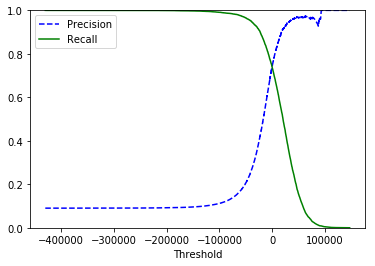

In [99]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

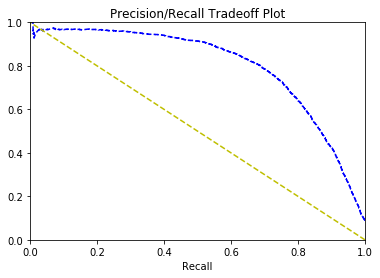

In [100]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(recalls[:-1], precisions[:-1],"b--", label="Precision")
    plt.plot([1,0],[0,1],"y--") #not sure if this is good to do for this graph, it looks cooL!
    plt.axis([0,1,0,1])
    plt.xlabel("Recall")
    plt.title("Precision/Recall Tradeoff Plot")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

<font color=red> Now you can simply select the threshold value that gives you the best precision/recall tradeoff for
your task. Another way to select a good precision/recall tradeoff is to plot precision directly against
recal. </font>

# Pro tip:

It is fairly easy to create a classifier with virtually any precision you want: just set a high enough threshold and you're done! NOT SO FAST DUMBO!!! A high precision classifer is not very useful if recall is too low. 

<font color=red> If someone says "lets reach 99% recision" you should ask, "at what recall?"</font>

# The ROC Curve
The receiver operating characteristic curve (ROC) is another common tool used with binary classifiers. Its similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC plots the:
- true positive rate (TPR) (another name for recall) vs 
- the false positive rate (FPR).

The FPR is the ratio of negative instances that are incorrectly classified as positive. **It is equal
to one minus the true negative rate**, which is the ratio of negative instances that are correctly classified as negative. **The TNR is also called specificity.** 

<font color=red> Hence the ROC curve plots sensitivity
(recall) versus (1 – specificity).
To plot the ROC curve, you first need to compute the TPR and FPR for various threshold values,
using the roc_curve() function:</font>

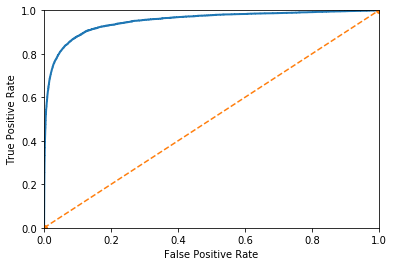

In [101]:
from sklearn.metrics import roc_curve

fpr,tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr,tpr,lw, label=None):
    plt.plot(fpr,tpr,linewidth=lw,label=label)
    plt.plot([0,1],[0,1],'o--') #r-- creates an orange line. Neat!
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr,lw=2)
plt.show()

Once again, there is a tradeoff: higher recall (TPR), the higher the false positive rate will be (FPR). The orange dotted line represents the ROC curve of a purel random classifier; **a good classifier stays as far away from that line as possible (toward the top left hand corner).**

<font color=red> One way to compare classifiers is to measure the area under the curve (AUC). **A perfect classifier
will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to
0.5.</font>

In [102]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.95129282922595781

# PRO TIP:
Since the ROC curve is so similar to the precision/recall (or PR) curve, you may wonder how to decide which one to use.
As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the
false positives than the false negatives, and the ROC curve otherwise. **For example, looking at the previous ROC curve
(and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few
positives (5s) compared to the negatives (non-5s).**<font color=blue> In contrast, the PR curve makes it clear that the classifier has room for
improvement (the curve could be closer to the top-right corner).</font>

# RandomForestClassifier
Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the
SGDClassifier. First, you need to get scores for each instance in the training set. **But due to the way
it works, the RandomForestClassifier class does not have a
decision_function() method. Instead it has a predict_proba() method. Scikit-Learn classifiers
generally have one or the other.** The predict_proba() method returns an array containing a row per
instance and a column per class, each containing the probability that the given instance belongs to the
given class (e.g., 70% chance that the image represents a 5)


In [103]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method='predict_proba')

y_predicts_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

print(y_probas_forest[0:5])
print(y_predicts_forest[0:5])

[[ 1.   0. ]
 [ 0.9  0.1]
 [ 1.   0. ]
 [ 1.   0. ]
 [ 1.   0. ]]
[False False False False False]


In [104]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

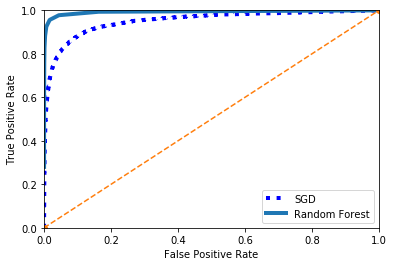

ROC Score:  0.9931243366
Precision Score:  0.985297344744
Recall Score:  0.828260468548


In [105]:
plt.plot(fpr, tpr, "b:", linewidth=4,label="SGD")
plot_roc_curve(fpr_forest, tpr_forest,lw=4,label="Random Forest")
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_score, recall_score
print("ROC Score: ", roc_auc_score(y_train_5, y_scores_forest))
print("Precision Score: ", precision_score(y_train_5, y_predicts_forest))
print("Recall Score: ", recall_score(y_train_5, y_predicts_forest))

Whoa the RFC really kicks ass for this task! Even better than the SGD classifier! Neat! 

**Sooo its important to remember that the ROC score is kind of a blend of the thresholds and results. While the Precision and Recall scores are a straight measure of the predictions and the actuals using the default threshold. They require different inputs, as you see in the code above. **
- ROC Score requires actuals and probabilities
- Precision/Recall requires actuals and predictions (1 or 0)

# Multiclass Classification

These algorithms fall into two main categories:
1. Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are capable of handling multiple classes directly. 
2. Others (such as Support Vector Machine classifiers or Linear
classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification using multiple binary classifiers.

In regards to the second option, there are a few approaches:

**ONE VS ALL:** one way to create a system that can classify the digit images into 10 classes (from 0 to
9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so
on). Then when you want to classify an image, you get the decision score from each classifier for that
image and you select the class whose classifier outputs the highest score. This is called the oneversus-
all (OvA) strategy (also called one-versus-the-rest). **THIS IS PREFERED FOR MOST BINARY CLASSIFICATION ALGOS**

**ONE VS ONE**: Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s,
another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one
(OvO) strategy. If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST
problem, this means training 45 binary classifiers!

<font color=red size=4>SKlearn detects when you try to use a binary classifier algo for a multiclass task, and it automatically runs OvA (except for SVM classifiers which is usede OvO.).</font>

In [116]:
sgd_clf.fit(X_train,y_train)
print(sgd_clf.predict([some_digit]))

some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

[ 5.]


array([[ -39554.50120878, -131473.18772541,  -48613.51252381,
           -216.17646426,  -94992.13611376,    2687.95095208,
        -116986.02309052,  -65779.59263147,  -57036.59225425,
         -56624.74228734]])

Neat! It seems to work and predict correctly when training with ALL the 10 classes in y_train. **Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the high score.** Amazing.

# PRO TIP:

When a classifier is trained, it stores the list of its target classes in its 'classes' attribute, ordered by value. See below:

In [117]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

**If you do want to force SKLearn to use one-versus-one or one-versus-all, you can use the OneVsOneClassifier or OneVsRestClassifier class. ** Simply create an instance and pass a binary classifer to its constructure. For instance:

In [118]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
ovo_clf.fit(X_train, y_train)
print('Prediction on some digit: ',ovo_clf.predict([some_digit]))
print('Num. Estimators: ',len(ovo_clf.estimators_))

Prediction on some digit:  [ 5.]
Num. Estimators:  45


Training a RandomForestClassifier is even easy, as you do not have to run OvA or OvO because Random Forest Classifiers can directly classify instances into multiple classes. **You can use predict_proba() to get the list of probabilities that the classifier assigned to each instance.**

In [110]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [119]:
forest_clf.predict_proba([some_digit])

array([[ 0.1,  0. ,  0. ,  0.1,  0. ,  0.8,  0. ,  0. ,  0. ,  0. ]])

Let's take a look at how the random forest classifer performs!

In [122]:
print("RF scores: ", cross_val_score(forest_clf,X_train,y_train, cv=3,scoring='accuracy'))
print("SGD scores: ", cross_val_score(sgd_clf,X_train,y_train, cv=3, scoring='accuracy'))

RF scores:  [ 0.94041192  0.93879694  0.93949092]
SGD scores:  [ 0.88872226  0.88659433  0.84577687]


# Feature Scaling

Looks like we got above 80% for the SGD on all folds. Thats pretty good. A totally random classifier would only predict the right number about 10% of the time, so 80% is obviously a good first step. But theres room for improvement, first lets do feature scaling!!! There are a few options here:

- **Min-max scaling (normalization):** values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and by the max minus min. Scikitlearn provides a MinMaxScaler for this. it also has a 'feature_range' hyper parameter so u can change the range if you don't want 0-1. 
- **Standardization:** This is quite different from normalization. First it subtracts the mean value *(so standardized values always have a zero mean)*, and then it divides by the variance so that the resulting distribution has a unit variance. Unlike min-max scaling, standardization does not bound the values to a specific range, which may be a problem for some algos (eg. neural nets often expect an input to range from 0-1).  

**Key: Standardization is much less affected by outliers. If we had a median income in our housing data of 100 (by mistake), min-max scaling would then crush all other values from 0-15 down to 0-0.15, wheras standadization would not be much affected. Scikit-Learn provides a StandardScaler transormer for standardization. **

Lets do some features scaling on our data and see if it improves the SGDClassifier model we just made. 

In [113]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_train_scaled[0:5]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [124]:
print("RF scores: ", cross_val_score(forest_clf,X_train_scaled,y_train, cv=3,scoring='accuracy'))
print("SGD scores: ", cross_val_score(sgd_clf,X_train_scaled,y_train, cv=3, scoring='accuracy'))

RF scores:  [ 0.94041192  0.93894695  0.93929089]
SGD scores:  [ 0.90116977  0.90104505  0.90003501]


Woooohoooo over 90% on each fold for the SGD! Simply scaling the features improves out model by approximately 10%. Sick!!!



<p> <font color=red> HOWEVER, not the scores did not really improve AT ALL for the random forest model. This is because scaling features doesnt really affect the algorithm. More on this later!</font> </p>

# Error Analysis

So, if this were a real project, you would now follow the steps in the Machine Learning project checklist, including exploring data preparation options, trying multiple models, shortlising the best ones and fine tuning their hyper parameters using GridSearchCV, and automating as much as possible. To recap, there are eight main steps:

1. Frame the problem and look at the big picture.
2. Get the data.
3. Explore the data to gain insights.
4. Prepare the data to better expose the underlying data patterns to Machine Learning algorithms.
5. Explore many different models and short-list the best ones.
6. Fine-tune your models and combine them into a great solution.
7. Present your solution.
8. Launch, monitor, and maintain your system.

HOWEVER, here we will assume that we have found a promising model and we now want to find ways to improve it! **One way to do this is to analyze the types of errors it makes. First step is to look at the confusion matrix.**

In [120]:
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
print('First ten: ',y_train_pred[0:10])

conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

First ten:  [ 1.  6.  6.  1.  1.  8.  2.  2.  1.  8.]


array([[5592,    0,   16,    9,   10,   44,   37,    6,  208,    1],
       [   0, 6423,   42,   21,    3,   40,    4,    9,  191,    9],
       [  24,   25, 5264,   91,   72,   26,   65,   40,  342,    9],
       [  30,   22,  113, 5255,    2,  202,   27,   45,  370,   65],
       [  10,   18,   39,   11, 5242,   10,   39,   20,  297,  156],
       [  31,   22,   25,  163,   52, 4465,   76,   22,  510,   55],
       [  27,   19,   44,    2,   41,   93, 5558,    4,  130,    0],
       [  22,   13,   56,   21,   49,   12,    5, 5717,  167,  203],
       [  19,   66,   38,  106,    2,  120,   29,   10, 5419,   42],
       [  23,   21,   31,   60,  124,   35,    1,  183,  361, 5110]], dtype=int64)

<font color = red size=5> Hmmm that is a lot of numbers! It is probably more useful to visualize this data somewhow. You can do this with Matplotlib's matshow() funciton:</font>

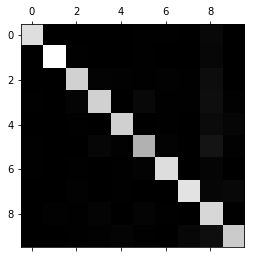

In [125]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

Nice! This looks pretty good, since most images are on the main diagonal (which means correct classifications!).** The 5s look slightly darker than the other digits, which could mean that they were fewer images of the 5s in the data set, or the classifier does NOT perform as well on 5s as it does on other digits.** We can verify both of these.

Lets now focus the plot on the errors: 
1. *First, you need to divide each value in the confusion matrix by the number of images in the corresponding class*, **so you can compare error rates instead of absolute number of errors (which would make abundant classes look unfairly bad). **
2. <font color = blue> Then we fill the diagonal with zeros to keep ONLY the errors</font>

In [138]:
# step 1
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
print(np.around(norm_conf_mx, decimals=3))

[[ 0.944  0.     0.003  0.002  0.002  0.007  0.006  0.001  0.035  0.   ]
 [ 0.     0.953  0.006  0.003  0.     0.006  0.001  0.001  0.028  0.001]
 [ 0.004  0.004  0.884  0.015  0.012  0.004  0.011  0.007  0.057  0.002]
 [ 0.005  0.004  0.018  0.857  0.     0.033  0.004  0.007  0.06   0.011]
 [ 0.002  0.003  0.007  0.002  0.897  0.002  0.007  0.003  0.051  0.027]
 [ 0.006  0.004  0.005  0.03   0.01   0.824  0.014  0.004  0.094  0.01 ]
 [ 0.005  0.003  0.007  0.     0.007  0.016  0.939  0.001  0.022  0.   ]
 [ 0.004  0.002  0.009  0.003  0.008  0.002  0.001  0.913  0.027  0.032]
 [ 0.003  0.011  0.006  0.018  0.     0.021  0.005  0.002  0.926  0.007]
 [ 0.004  0.004  0.005  0.01   0.021  0.006  0.     0.031  0.061  0.859]]


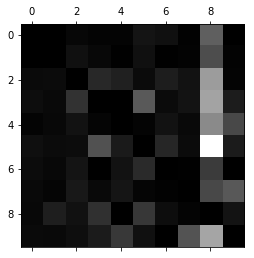

In [140]:
# step 2
np.fill_diagonal(norm_conf_mx,0) #fill diagonal with zeros to highlight other differences
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Neat! Now we can clearly see where the biggest errors are. White mean high numbers, so they are the highest numbers. **Remember the ROWS represent actual classes, while COLUMNS represent predicted classes.** 
- The columns for 8 and 9 are quite bright, which tells you many images are misclassified as 8 or 9. 
- Similarily the rows for classes 8 and 9 are also quite bright, telling you that 8s and 9s are often confused with other digits. 
- Conversly some rows are pretty dark, such as row 1. meaning that most 1s are classified correctly. 
- Notice that that erors are not perfeclty symmetrical; for example there are mroe 5s misclassified as 8s than the reverse.

<font color=red> Analyzing confusing matrix can often give you insihgts on ways to improve your classifier. Looking at this ploit, it seems that your efforts should be spent on improving classifications of 8s and 9s, as wel, as well as fixing the specific 3/5 confusion. For example:</font>
- you could try to gather more training data for these digits.
- or you could engineer new features that would help the classifier:
    - for example writing an algorithm to count the number of closed loops (eg. 8 has two, 6 has one, 5 has none). 
- Or you could preprocess the imagines (eg using Scikit-Image, Pillow, or OpenCV) to make some patterns stand out more, such as closed loops. 

# Analyzing indidivual errors

Analyzing individual errors can also be a good way to gain insights on errors, but its often more difficult. For example, lets plot 3s and 5s.

In [141]:
# set up plot_digit and plot_digits functions

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

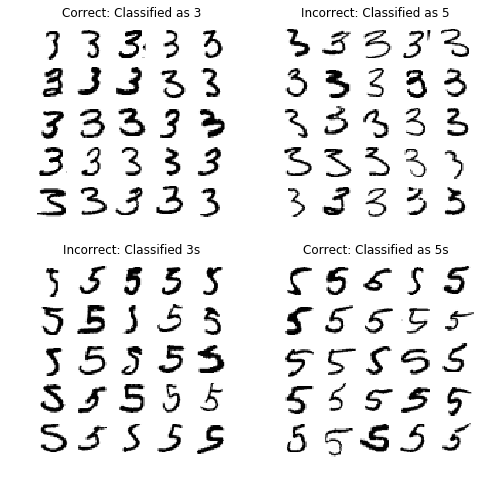

In [142]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))

plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.title('Correct: Classified as 3')
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.title('Incorrect: Classified as 5')
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.title('Incorrect: Classified 3s')
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.title('Correct: Classified as 5s')
plt.show()

#Note, not sure if I got these titles right!

**The 5x5 blocks on the left show digits classified as 3s, and the two blocks on the right show images classified as 5s.**  Some fo the digits that the classifier gets wrong (in the bottom left and top right blocks) are so badly written even human eyes couldnt guess. However most classified images seem like obvious errors to us, and its hard to understand why the classifier made the mistakes it did. 

***But remember that our brain is a fantastic pattern recognition system, and our visual system does a lot of complex preprocessing before any information reaches our consciousness, so the fact that it feels simple does not mean that it is. ***

<Font color=red size=5>The reason is that we used a simple SGDClassifier, which is a linear model. All it does it assign a weight per class to each pixel, and when it sees a new image it just sums up the weigted pixel intensites to get a score for each class. So since 3s and 5s differ only by a few pixels, this model will easily confuse them.</font>

The main difference between 3s and 5s is the position of the small line that joins the top line to the bottom arc. In other words, this classifier is quite sensitive to image shifting and rotation. So one way to reduce the 3/5 confusion would be to preprocess the images to ensure that they are all well centered and not too rotated. This will probably help reduce errors. 


# Multilabel Classification
Until now each instance has always been assigned to just one class. In some cases you may want your ouput to have multiple classes for each instance!!! For consider a face-recognition classifier: what if you want to classifier to recognize multiple poeple in the picture?

We won't get into face recognition just yet, but lets look at a simple example, just for illustration purposes:

In [143]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd] #create multiclass matrix
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ..., 
       [False, False],
       [False, False],
       [ True,  True]], dtype=bool)

In [144]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Thi code creates a **y_mulilable array, containing two target labels** for each image: the first indicates whether or not eh digit is large (7,8,9) and the second indicates whether or not it is odd. The next bit creates a KNeightborsClassifier instance **(which supports multilabel classification, BUT NOT ALL CLASSIFIERS DO), and we train the model using the multiple targets array!**

In [145]:
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

Woohooo its right! 5 is indeed non large (False) and odd (True). 

There are many ways to evaluate a multilabel classifie, but selecting the right metric really depends on your project. One approach is to measure the F1 score for each individual label, then simply compute the average score. 

This assumes that all labels are important, which may not be true. For example, if you have many pictures of Alice than Bob or Charline, you may want to give more weight to the classifiers score on pictures of Alice. 
- Weighted classes: one way to address this is to give each label a weight equal to its *support* (ie. the number of instances with that target label). To do this, simple set *average="weighted"* in the preceding code.

**Warning:** *the following cell may take a very long time (possibly hours depending on your hardware). I think this is because KNN uses all the data and is therefore super slow!!! Whats the name for this kind of model again?*

In [146]:
#y_train_knn_pred = cross_val_predict(knn_clf, X_train,y_multilabel, cv=3)
#f1_score(y_multilabel, y_train_knn_pred, average='macro')

# Multioutput Classification

Last type of classificaiton we cover in this chapter is multioutput-multiclass classification. It is simply a generalization of the multilabel classification where each label can be multiclass (ie. it can have more than two possible values). 

To illustrate, lets build a sustem thta removes noise from images. It will take as input a noisy digit image, and it will (hopefully) output a clean digit image, respresented as an array of pixel intensities, just like the MNIST images. Notice that the classifier's output is multilabel (one label per pixel) and each label can have multiple vales (pixel intensity ranges from 0 to 255). It is this an example of a multiouput classificaiton system. 

**NOTE: The line between classification and regression is sometimes blurry, such as in this example. Arguably, predicting pixel
intensity is more akin to regression than to classification. Moreover, multioutput systems are not limited to classification
tasks; you could even have a system that outputs multiple labels per instance, including both class labels and value labels.**

Let’s start by creating the training and test sets by taking the MNIST images and adding noise to their
pixel intensities using NumPy’s randint() function. The target images will be the original images:

In [147]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

# Now we set the y variable to the original observation! 
y_train_mod = X_train
y_test_mod = X_test

Let’s take a peek at an image from the test set (yes, we’re snooping on the test data, so you should be
frowning right now).

On the left is the noisy input image, and on the right is the clean target image. **Now let’s train the
classifier and make it clean this image:**

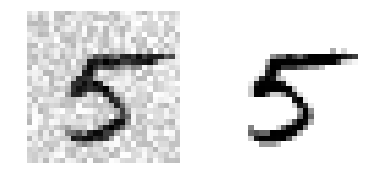

In [148]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

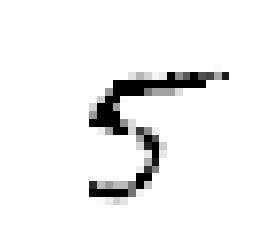

In [149]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

Looks close enough to the target! This concludes our tour of classification. Hopefully you should now
know how to select good metrics for classification tasks, pick the appropriate precision/recall
tradeoff, compare classifiers, and more generally build good classification systems for a variety of
tasks.